In [261]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Flatten, Activation, Dense
from tensorflow.keras.optimizers import SGD, Adam, schedules
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [262]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print("x_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("x_test shape", x_test.shape)
print("y_test shape", y_test.shape)

x_train shape (50000, 32, 32, 3)
y_train shape (50000, 1)
x_test shape (10000, 32, 32, 3)
y_test shape (10000, 1)


In [263]:
X_train = x_train.reshape(50000, 32, 32, 3)
X_test = x_test.reshape(10000, 32, 32, 3)

X_train = X_train.astype('float32')         
X_test = X_test.astype('float32')

X_train /= 255                              
X_test /= 255

In [264]:
nb_classes = 10

Y_train = utils.to_categorical(y_train, nb_classes)
Y_test = utils.to_categorical(y_test, nb_classes)

print(f"Y_train: {Y_train.shape}, Y_test: {Y_test.shape}")

Y_train: (50000, 10), Y_test: (10000, 10)


In [265]:
def plot_images(x, X, y):
    # Define number of rows & columns
    num_row = 2
    num_col = 8
    num = num_row * num_col
    
    # Plot before
    print('BEFORE:\n')
    fig1, axes1 = plt.subplots(num_row, num_col, figsize=(1.5 * num_col, 2 * num_row))
    for i in range(num):
        ax = axes1[i // num_col, i % num_col]
        ax.imshow(x[i])
        ax.set_title('Label: {}'.format(y[i]))
        ax.axis('off')
    plt.show()
    
    # Plot after
    print('AFTER:\n')
    fig2, axes2 = plt.subplots(num_row, num_col, figsize=(1.5 * num_col, 2 * num_row))
    for X_aug, Y_aug in datagen.flow(X, y, batch_size=num, shuffle=False):
        for i in range(0, num):
            ax = axes2[i // num_col, i % num_col]
            ax.imshow(X_aug[i])
            ax.set_title('Label: {}'.format(int(Y_aug[i])))
            ax.axis('off')
        break
    plt.show()

BEFORE:



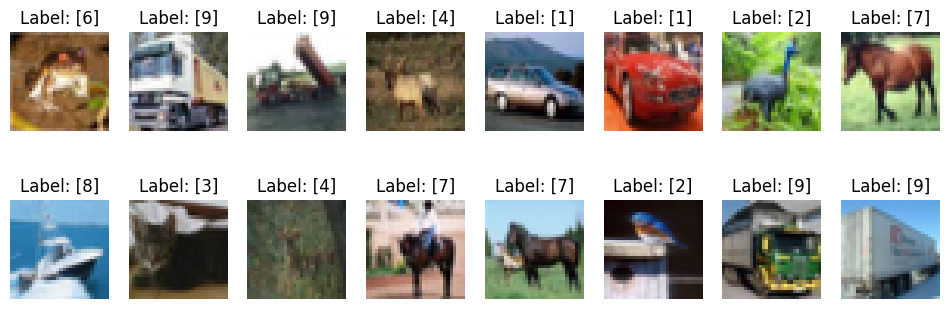

AFTER:



C:\Users\peter\AppData\Local\Temp\ipykernel_3336\2622081334.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title('Label: {}'.format(int(Y_aug[i])))


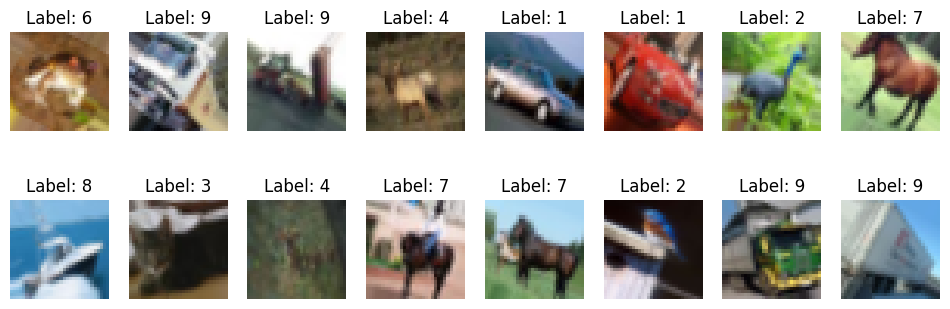

In [266]:
datagen = ImageDataGenerator(rotation_range=40)
datagen.fit(X_train)

plot_images(x_train, X_train, y_train)

BEFORE:



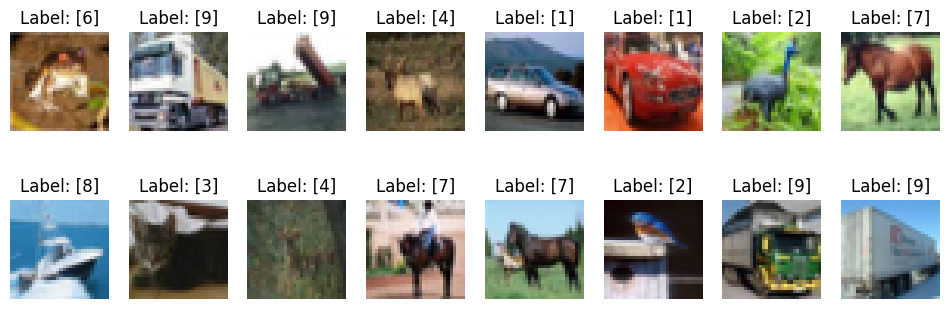

AFTER:



C:\Users\peter\AppData\Local\Temp\ipykernel_3336\2622081334.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title('Label: {}'.format(int(Y_aug[i])))


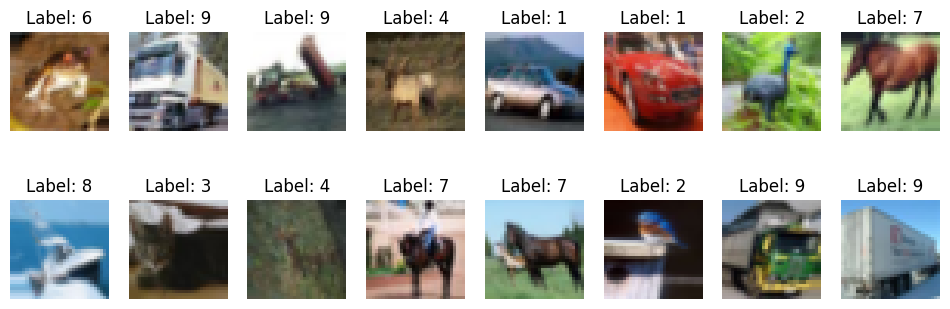

In [267]:
datagen = ImageDataGenerator(shear_range=20)
datagen.fit(X_train)

plot_images(x_train, X_train, y_train)

In [268]:
new_data = ImageDataGenerator(rotation_range=40, shear_range=20)
datagen.fit(X_test)

X_test_augmented, Y_test_augmented = next(datagen.flow(X_test, Y_test, batch_size=X_test.shape[0], shuffle=False))

In [269]:
# model = Sequential()

# model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3)))
# model.add(Activation('relu') )

# model.add(Conv2D(filters=32, kernel_size=(3, 3)))
# model.add(Activation('relu') )

# model.add(Conv2D(filters=32, kernel_size=(3, 3)))
# model.add(Activation('relu'))

# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(filters=64, kernel_size=(3, 3)))
# model.add(Activation('relu'))

# model.add(Conv2D(filters=64, kernel_size=(3, 3)))
# model.add(Activation('relu'))

# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(filters=128, kernel_size=(3, 3)))
# model.add(Activation('relu'))

# # model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())

# model.add(Dense(500))
# model.add(Activation('relu'))

# model.add(Dense(300))
# model.add(Activation('relu'))

# model.add(Dense(10))
# model.add(Activation('softmax'))

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [270]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3)))
model.add(Activation('relu') )

model.add(Conv2D(filters=32, kernel_size=(3, 3)))
model.add(Activation('relu') )

model.add(Conv2D(filters=32, kernel_size=(3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3)))
model.add(Activation('relu'))

model.add(Conv2D(filters=64, kernel_size=(3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3)))
model.add(Activation('relu'))

model.add(Flatten())

model.add(Dense(500))
model.add(Activation('relu'))

model.add(Dense(300))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [271]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_140 (Conv2D)         (None, 30, 30, 32)        896       
                                                                 
 activation_195 (Activation  (None, 30, 30, 32)        0         
 )                                                               
                                                                 
 conv2d_141 (Conv2D)         (None, 28, 28, 32)        9248      
                                                                 
 activation_196 (Activation  (None, 28, 28, 32)        0         
 )                                                               
                                                                 
 conv2d_142 (Conv2D)         (None, 26, 26, 32)        9248      
                                                                 
 activation_197 (Activation  (None, 26, 26, 32)      

In [272]:
model.fit(X_train, Y_train, batch_size = 128, epochs=10, verbose=1, validation_split = 0.2, validation_steps=12000//128)

Epoch 1/10
313/313 [==============================] - 25s 74ms/step - loss: 1.7667 - accuracy: 0.3372 - val_loss: 1.4923 - val_accuracy: 0.4548
Epoch 2/10
313/313 [==============================] - 21s 67ms/step - loss: 1.3758 - accuracy: 0.4964
Epoch 3/10
313/313 [==============================] - 21s 68ms/step - loss: 1.1935 - accuracy: 0.5713
Epoch 4/10
313/313 [==============================] - 21s 66ms/step - loss: 1.0524 - accuracy: 0.6259
Epoch 5/10
313/313 [==============================] - 21s 67ms/step - loss: 0.9305 - accuracy: 0.6706
Epoch 6/10
313/313 [==============================] - 21s 68ms/step - loss: 0.8353 - accuracy: 0.7042
Epoch 7/10
313/313 [==============================] - 21s 67ms/step - loss: 0.7452 - accuracy: 0.7407
Epoch 8/10
313/313 [==============================] - 21s 67ms/step - loss: 0.6829 - accuracy: 0.7588
Epoch 9/10
313/313 [==============================] - 22s 71ms/step - loss: 0.6083 - accuracy: 0.7860
Epoch 10/10
313/313 [===================

In [273]:
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

313/313 [==============================] - 2s 7ms/step - loss: 0.9060 - accuracy: 0.7037
Test loss: 0.9060
Test accuracy: 0.7037


In [274]:
datagen.fit(X_test)

# De resultaten slaan we op in een nieuwe dataset
X_test_augmented, Y_test_augmented = next(datagen.flow(X_test, Y_test, batch_size=10_000))

In [275]:
loss, accuracy = model.evaluate(X_test_augmented, Y_test_augmented)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

313/313 [==============================] - 2s 7ms/step - loss: 1.0090 - accuracy: 0.6672
Test loss: 1.0090
Test accuracy: 0.6672
